# Covid-19 v České republice

verze s API v3

In [1]:
# importy a funkce

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import json
import datetime as dt

plt.style.use('ggplot')

def autolabel(rects, ax, val_prec=0):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height!=height:height=0
        if val_prec == 0:
            height_str = f'{height:.0f}'
        elif val_prec == 1:
            height_str = f'{height:.1f}'            
        else:
            height_str = f'{height:.2f}'
        ax.annotate(height_str,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

with open('token.json') as token_file:
    data = json.load(token_file)
    token = data['token']

In [2]:
# získání základních dat
days_back = 49

dfs = []
for d in range(days_back,0,-1):
    data_date = (dt.date.today() - dt.timedelta(days=d)).strftime("%Y-%m-%d")
    with urllib.request.urlopen(f'https://onemocneni-aktualne.mzcr.cz/api/v3/nakazeni-vyleceni-umrti-testy/{data_date}?apiToken={token}') as url:
        
        json_data = pd.json_normalize(json.loads(url.read().decode()))
        dfs.append(json_data)
df = pd.concat(dfs, ignore_index=True)  
df = df.drop(['@context', '@id', '@type'], axis=1)
df['datum'] = pd.to_datetime(df['datum'], errors='coerce')
df['datum'] = df['datum'].dt.date


# získání dat o incidenci
data_date = (dt.date.today() - dt.timedelta(days=days_back)).strftime("%Y-%m-%d")

with urllib.request.urlopen(f'https://onemocneni-aktualne.mzcr.cz/api/v3/incidence-7-14-cr?datum%5Bafter%5D={data_date}&apiToken={token}') as url:
    data = json.loads(url.read().decode())


df_incidence = pd.json_normalize(data['hydra:member'])
df_incidence = df_incidence.drop(['@id', '@type', 'id'], axis=1)
df_incidence['datum'] = pd.to_datetime(df_incidence['datum'], errors='coerce')
df_incidence['datum'] = df_incidence['datum'].dt.date

with urllib.request.urlopen(f'https://onemocneni-aktualne.mzcr.cz/api/v3/incidence-7-14-okresy?page=1&datum%5Bafter%5D={data_date}&okres_lau_kod=CZ0100&apiToken={token}') as url:
    data = json.loads(url.read().decode())

df_incidence_praha = pd.json_normalize(data['hydra:member'])
df_incidence_praha = df_incidence_praha.drop(['@id', '@type', 'id'], axis=1)
df_incidence_praha['datum'] = pd.to_datetime(df_incidence_praha['datum'], errors='coerce')
df_incidence_praha['datum'] = df_incidence_praha['datum'].dt.date

In [3]:
# add daily counts + other params

df.rename(columns={'datum': 'date', 
                   'kumulativni_pocet_nakazenych': 'positive_total',
                  'kumulativni_pocet_vylecenych': 'recovered_total', 
                  'kumulativni_pocet_umrti': 'deceased_total',
                  'kumulativni_pocet_testu': 'tested_pcr_total',
                  'kumulativni_pocet_ag_testu': 'tested_ag_total',
                  'prirustkovy_pocet_nakazenych': 'positive_daily',
                  'prirustkovy_pocet_vylecenych': 'recovered_daily',
                  'prirustkovy_pocet_umrti': 'deceased_daily',
                  'prirustkovy_pocet_provedenych_testu': 'tested_pcr_daily',
                  'prirustkovy_pocet_provedenych_ag_testu': 'tested_ag_daily',}, inplace=True)

df['tested_total'] = df['tested_pcr_total'] + df['tested_ag_total']
df['tested_daily'] = df['tested_pcr_daily'] + df['tested_ag_daily']
df['positive_ratio'] = df['positive_daily'] / df['tested_daily']
df['active'] = df['positive_total'] - df['recovered_total'] - df['deceased_total'] 

## Vývoj počtu pozitivně testovaných

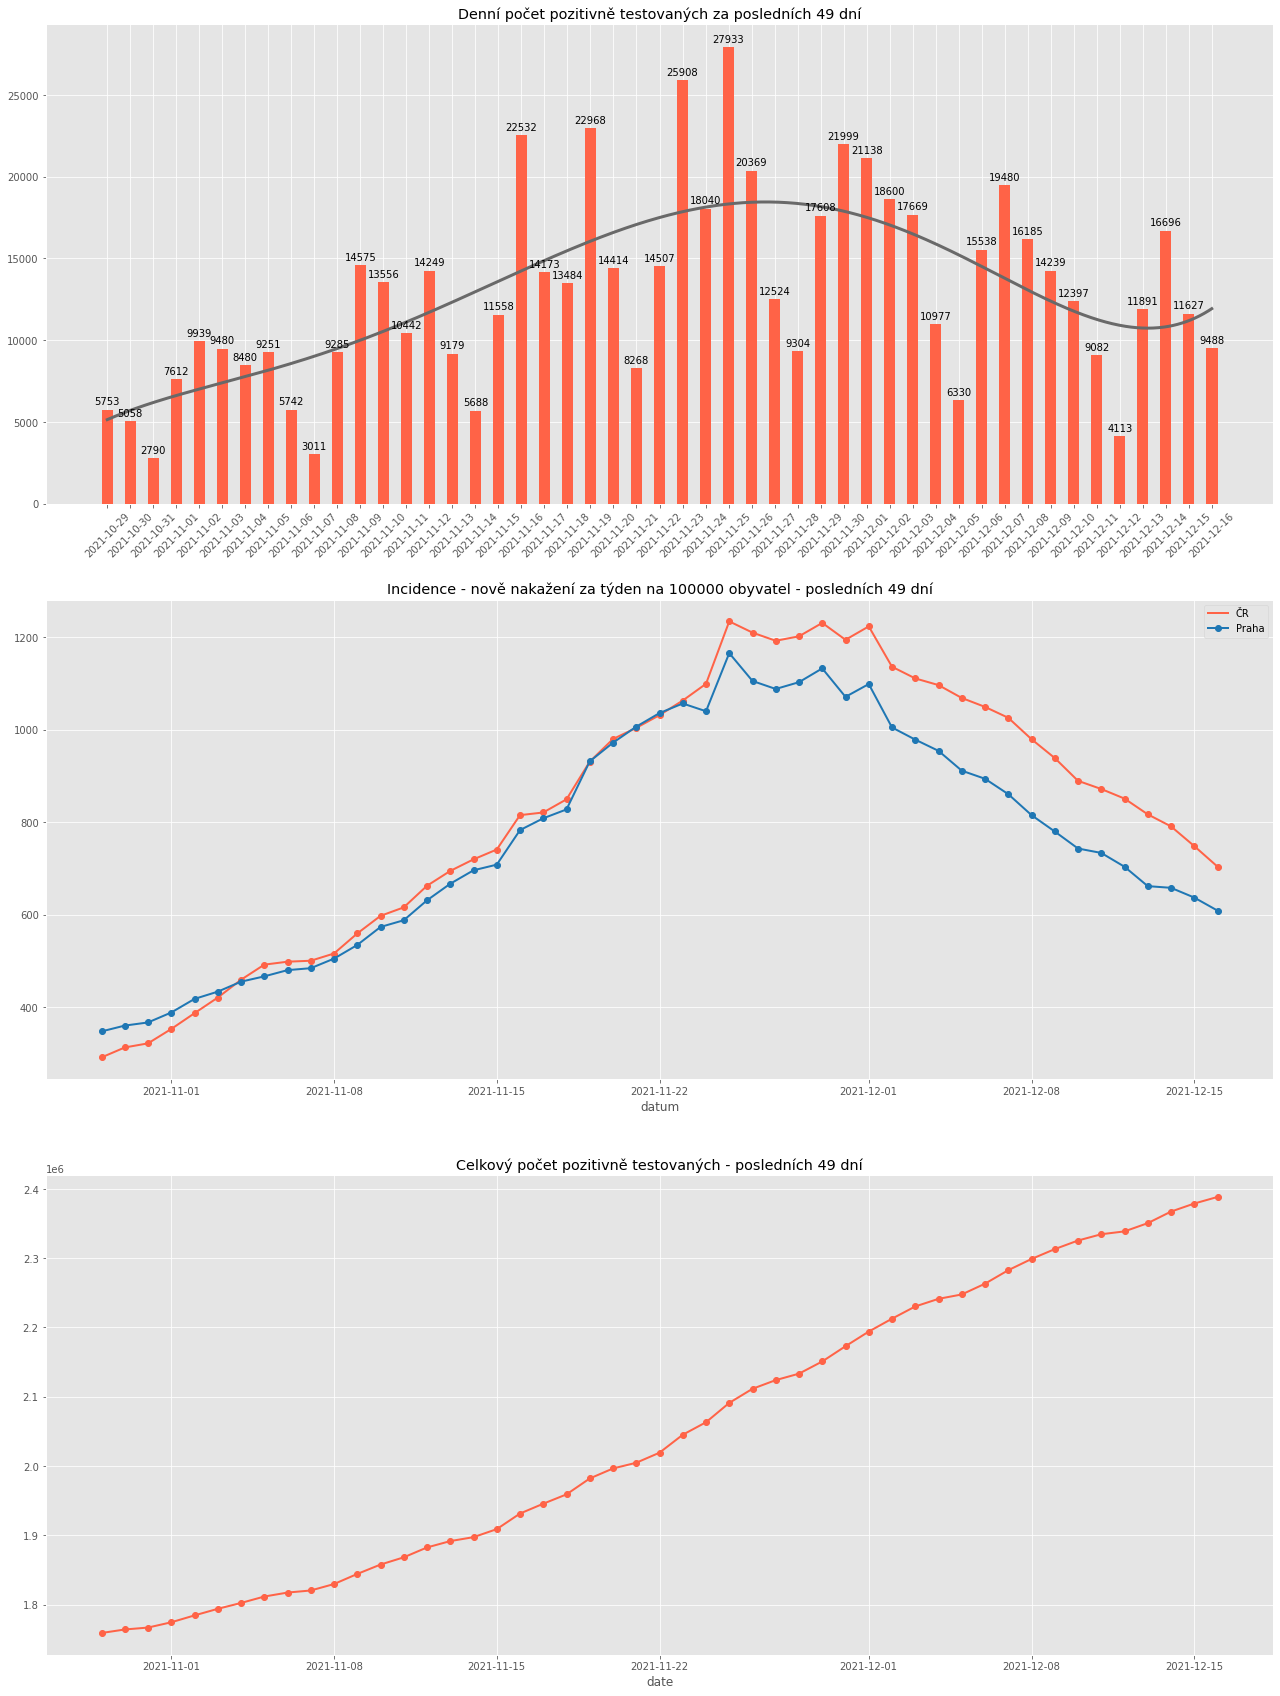

In [4]:
fig = plt.figure(figsize=(22,30))
ax1 = fig.add_subplot(313)
ax2 = fig.add_subplot(311)
ax3 = fig.add_subplot(312)

df.plot(x='date', 
        y='positive_total', 
        kind='line', 
        style='tomato',
        marker='o',
        linewidth=2,                   
        legend=False,
        grid=True, 
        ax=ax1,
        title=f'Celkový počet pozitivně testovaných - posledních {days_back} dní')

x = np.arange(days_back)
x_labels = np.array(df.iloc[-days_back:, df.columns.get_loc('date')])
y = np.array(df.iloc[-days_back:, df.columns.get_loc('positive_daily')])

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax2.bar(x, y, width=.5, color='tomato')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax2)

ax2.plot(xnew, p(xnew), 'dimgray', linewidth=3)

ax2.grid(True)
ax2.set_title(f'Denní počet pozitivně testovaných za posledních {days_back} dní')


df_incidence["incidence_7_100000"]=df_incidence["incidence_7_100000"].astype(float)
df_incidence.plot(x='datum', 
                    y='incidence_7_100000', 
                    kind='line', 
                    style='tomato',
                    marker='o',
                    linewidth=2,
                    label='ČR', 
                    legend=True,
                    grid=True, 
                    ax=ax3,
                    title='Incidence - nově nakažení za týden na 100000 obyvatel - posledních '+str(days_back)+' dní')

df_incidence_praha["incidence_7_100000"]=df_incidence_praha["incidence_7_100000"].astype(float)
df_incidence_praha.plot(x='datum', 
                        y='incidence_7_100000', 
                        kind='line', 
                        style='tab:blue',
                        marker='o',
                        linewidth=2,                                                      
                        label='Praha', 
                        legend=True,
                        grid=True, 
                        ax=ax3,
                    )

plt.show()

## Vývoj počtu testovaných

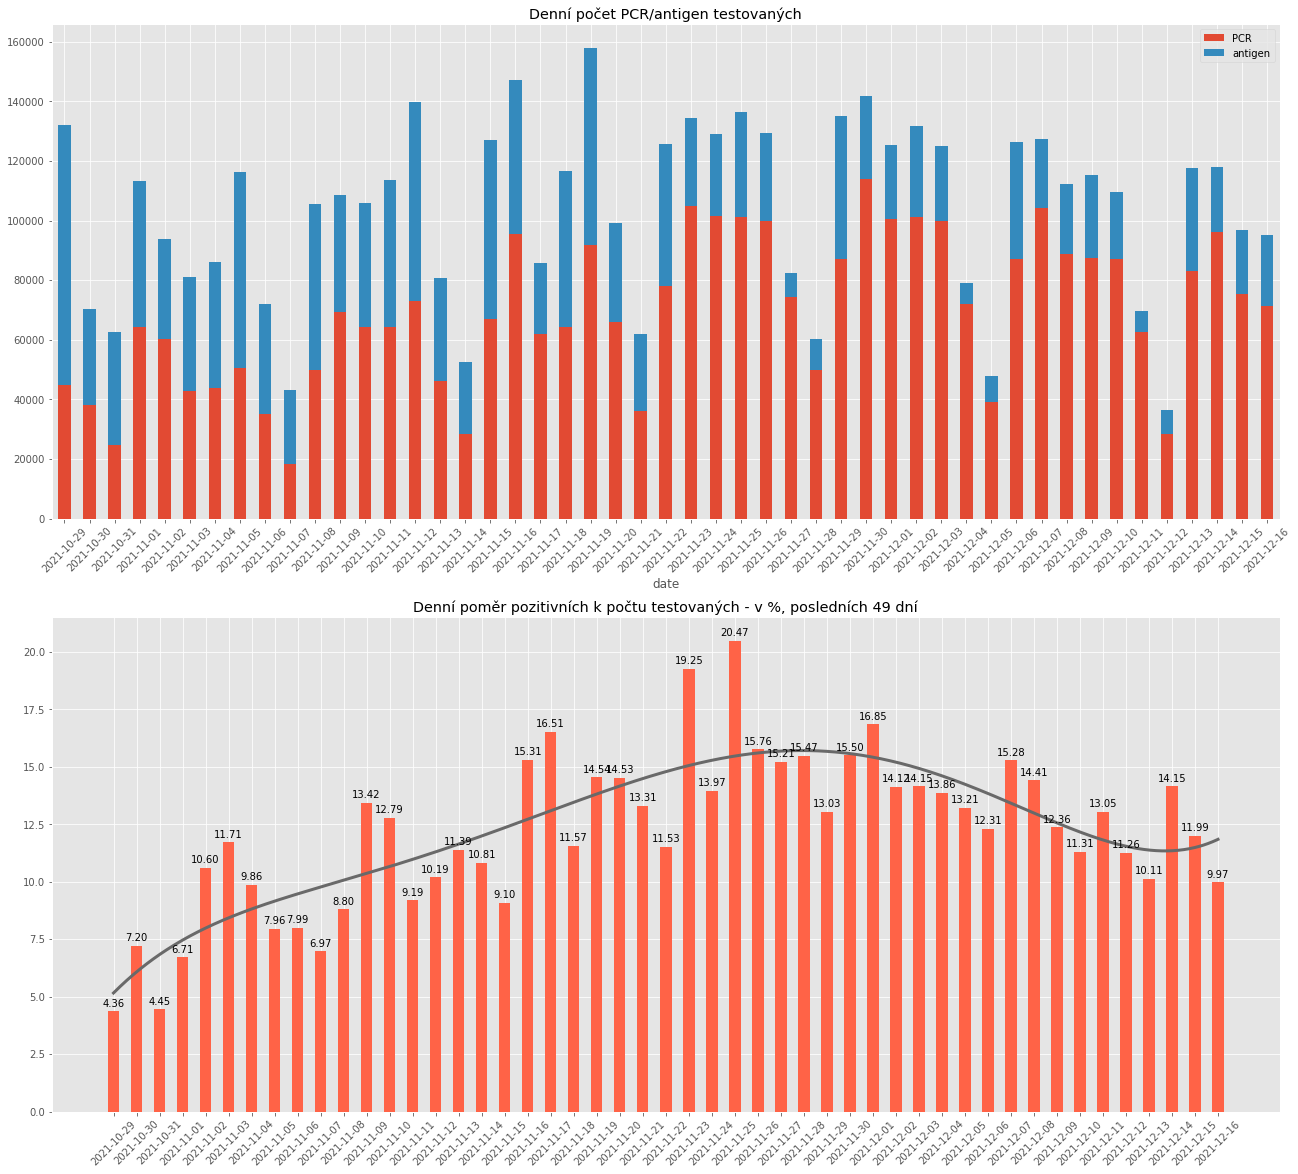

In [5]:
fig = plt.figure(figsize=(22,20))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

df.plot(x='date', 
        y=['tested_pcr_daily','tested_ag_daily'], 
        kind='bar',
        style=['tomato', 'dimgray'],
        linewidth=3,
        stacked=True,
        grid=True, 
        legend=True,
        label=['PCR','antigen'],
        ax=ax1,                        
        title='Denní počet PCR/antigen testovaných')
ax1.tick_params(axis="x", rotation=45) 

days_back = 49

x = np.arange(days_back)
x_labels = np.array(df.iloc[-days_back:, df.columns.get_loc('date')])
y = np.array(100*df['positive_ratio'])

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax2.bar(x, y, width=.5, color='tomato')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax2, val_prec=2)

ax2.plot(xnew, p(xnew), 'dimgray', linewidth=3)

ax2.grid(True)
ax2.set_title(f'Denní poměr pozitivních k počtu testovaných - v %, posledních {days_back} dní')
plt.show()

# Počty uzdravených a zemřelých

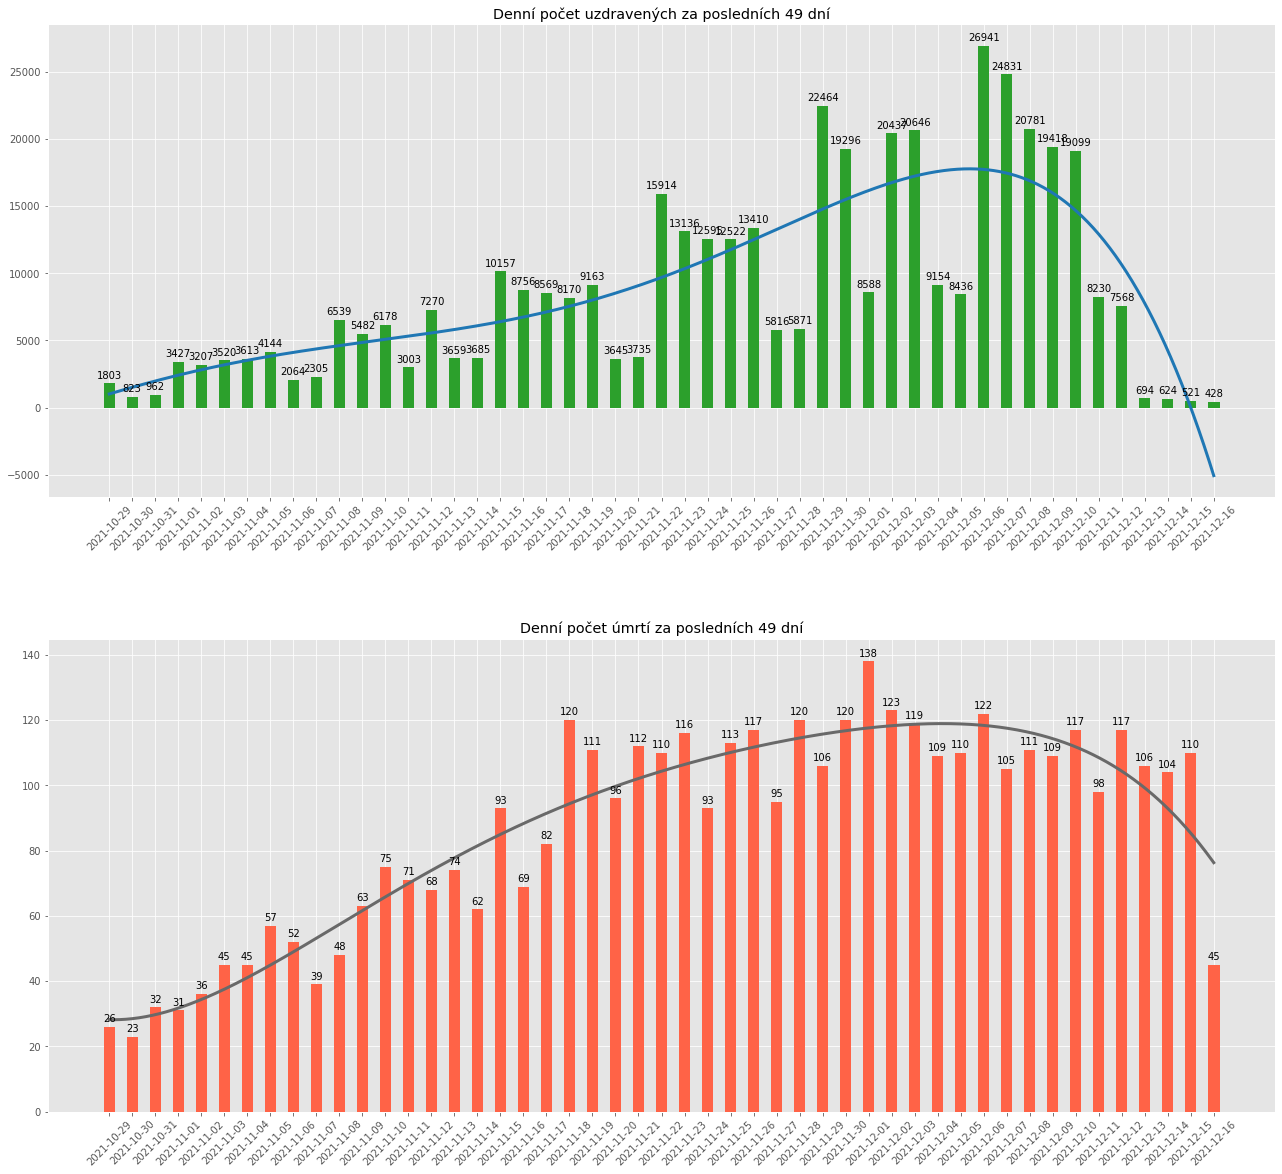

In [6]:
fig = plt.figure(figsize=(22,20))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

x = np.arange(days_back)
x_labels = np.array(df['date'])
y = np.array(df['recovered_daily'])

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax1.bar(x, y, width=.5, color='tab:green')
ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax1)

ax1.plot(xnew, p(xnew), 'tab:blue', linewidth=3)
ax1.set_title(f'Denní počet uzdravených za posledních {days_back} dní')
plt.subplots_adjust(hspace=0.3)


x = np.arange(days_back)
y = np.array(df['deceased_daily'])

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects2 = ax2.bar(x, y, width=.5, color='tomato')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
autolabel(rects2, ax2)

ax2.plot(xnew, p(xnew), 'dimgray', linewidth=3)
ax2.set_title(f'Denní počet úmrtí za posledních {days_back} dní')

plt.show()

In [7]:
# save data for later use
df.to_csv('data-' + df.iloc[-1, 0].strftime('%Y-%m-%d') + '.csv', index=False)

## Vliv očkování na úmrtí, umístění na JIP, nákazu

Zatím nejsem schopen získat denní počet osob s ukončeným očkováním, tak beru data z jednoho data:

- počet obyvatel ČR: 10 701 777
- počet očkovaných alespoň první dávkou k 11.12.2021: 6 735 225    (k 19.11. 6 498 082)
- počet neočkovaných k 19.11.2021: 4 203 695

In [8]:
residents = 10701777
vax = 6735225
novax = residents - vax #4203695

# data o úmrtí, jip, poztivitě podle očkování
data_date = (dt.date.today() - dt.timedelta(days=days_back)).strftime("%Y-%m-%d")

with urllib.request.urlopen(f'https://onemocneni-aktualne.mzcr.cz/api/v3/ockovani-umrti?page=1&datum%5Bafter%5D={data_date}&apiToken={token}') as url:
    data = json.loads(url.read().decode())


df_ocko_umrti = pd.json_normalize(data['hydra:member'])
df_ocko_umrti = df_ocko_umrti.drop(['@id', '@type', 'id'], axis=1)
df_ocko_umrti['datum'] = pd.to_datetime(df_ocko_umrti['datum'], errors='coerce')
df_ocko_umrti['datum'] = df_ocko_umrti['datum'].dt.date
df_ocko_umrti['zemreli_bez_ockovani_relative'] = 1e6 * df_ocko_umrti['zemreli_bez_ockovani'] / novax
df_ocko_umrti['zemreli_ockovani_relative'] = 1e6 * (df_ocko_umrti['zemreli_nedokoncene_ockovani'] + \
                                                df_ocko_umrti['zemreli_dokoncene_ockovani'] + \
                                                df_ocko_umrti['zemreli_posilujici_davka'])/ vax

with urllib.request.urlopen(f'https://onemocneni-aktualne.mzcr.cz/api/v3/ockovani-jip?page=1&datum%5Bafter%5D={data_date}&apiToken={token}') as url:
    data = json.loads(url.read().decode())


df_ocko_jip = pd.json_normalize(data['hydra:member'])
df_ocko_jip = df_ocko_jip.drop(['@id', '@type', 'id'], axis=1)
df_ocko_jip['datum'] = pd.to_datetime(df_ocko_jip['datum'], errors='coerce')
df_ocko_jip['datum'] = df_ocko_jip['datum'].dt.date
df_ocko_jip['jip_bez_ockovani_relative'] = 1e6 * df_ocko_jip['jip_bez_ockovani'] / novax
df_ocko_jip['jip_ockovani_relative'] = 1e6 * (df_ocko_jip['jip_nedokoncene_ockovani'] + \
                                                df_ocko_jip['jip_dokoncene_ockovani'] + \
                                                df_ocko_jip['jip_posilujici_davka'])/ vax


with urllib.request.urlopen(f'https://onemocneni-aktualne.mzcr.cz/api/v3/ockovani-pozitivni?page=1&datum%5Bafter%5D={data_date}&apiToken={token}') as url:
    data = json.loads(url.read().decode())


df_ocko_positive = pd.json_normalize(data['hydra:member'])
df_ocko_positive = df_ocko_positive.drop(['@id', '@type', 'id'], axis=1)
df_ocko_positive['datum'] = pd.to_datetime(df_ocko_positive['datum'], errors='coerce')
df_ocko_positive['datum'] = df_ocko_positive['datum'].dt.date
df_ocko_positive['pozitivni_bez_ockovani_relative'] = 1e5 * df_ocko_positive['pozitivni_bez_ockovani'] / novax
df_ocko_positive['pozitivni_ockovani_relative'] = 1e5 * (df_ocko_positive['pozitivni_nedokoncene_ockovani'] + \
                                                df_ocko_positive['pozitivni_dokoncene_ockovani'] + \
                                                df_ocko_positive['pozitivni_posilujici_davka'])/ vax

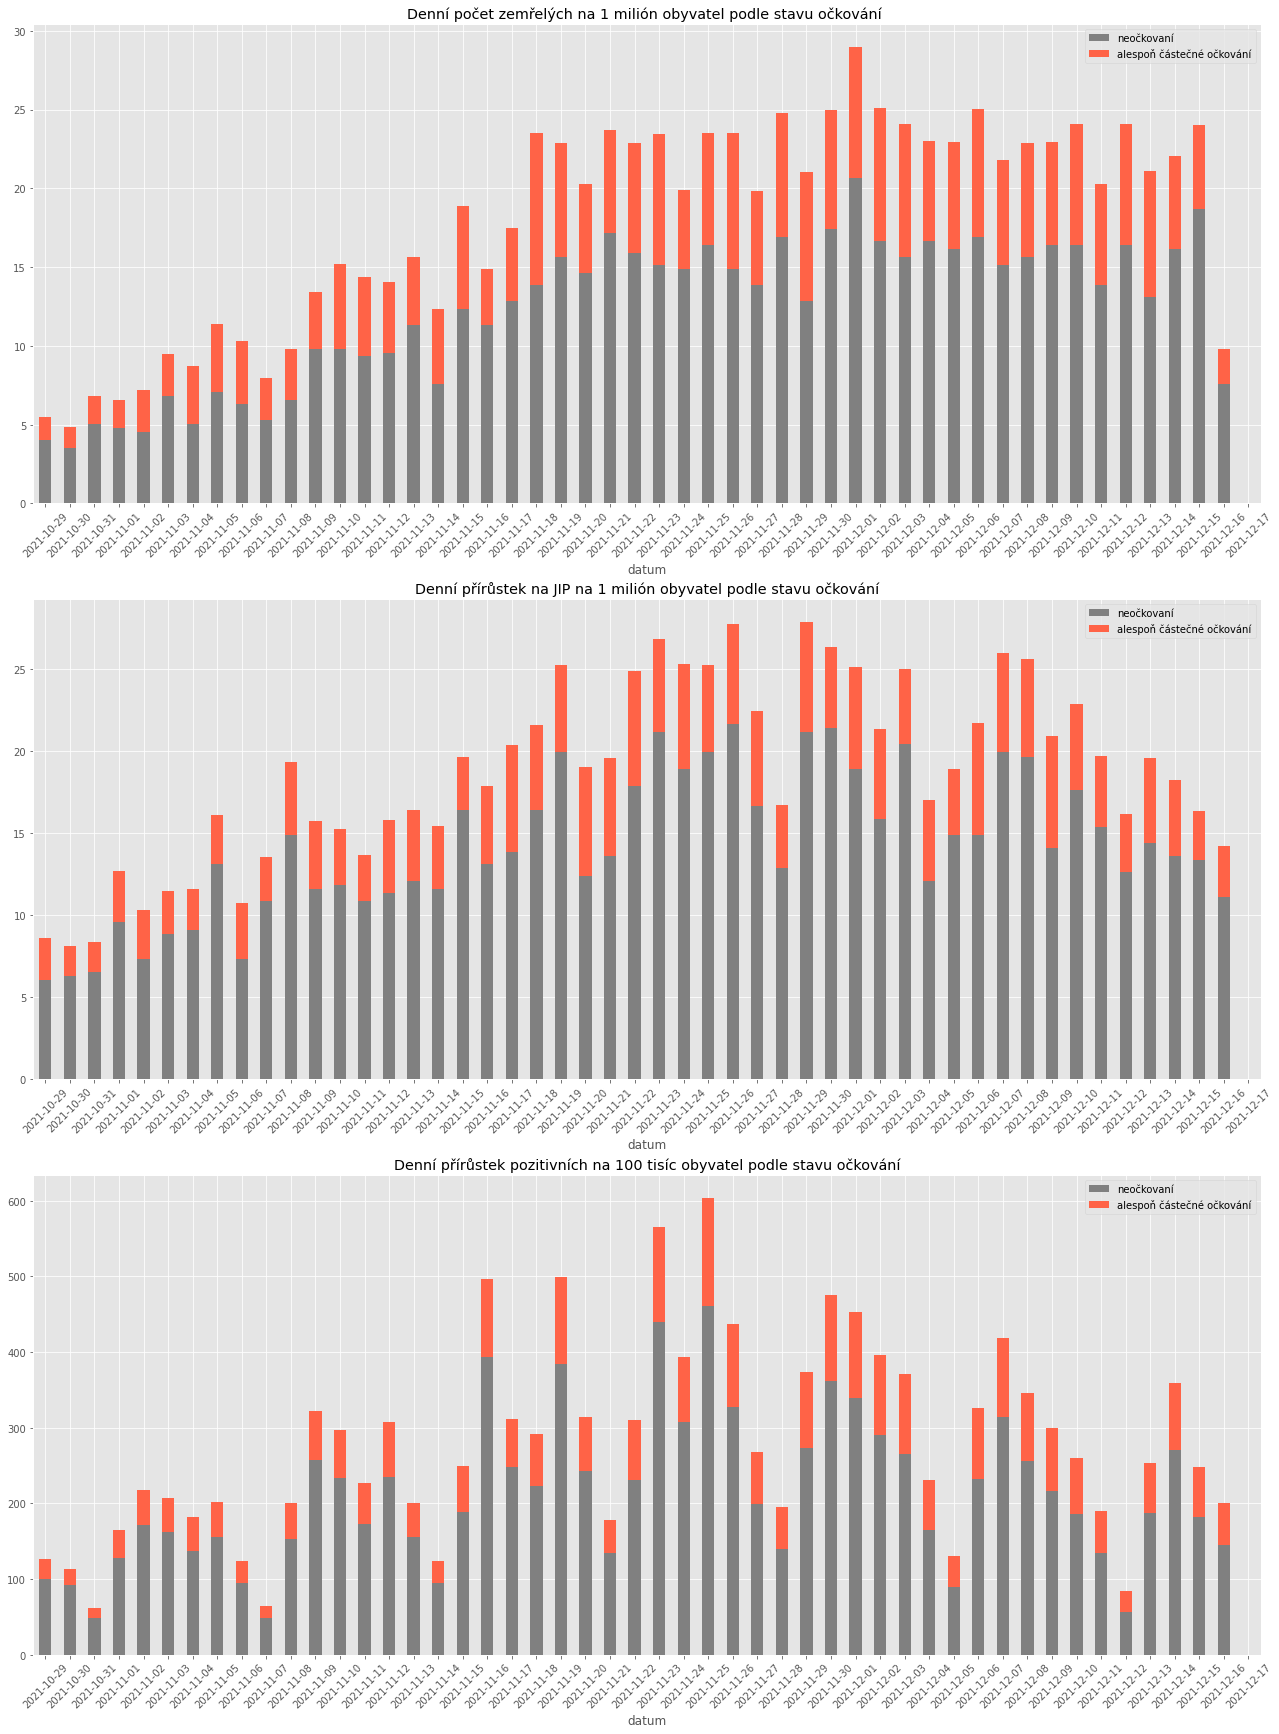

In [9]:
fig = plt.figure(figsize=(22,30))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

df_ocko_umrti.plot(x='datum', 
        y=['zemreli_bez_ockovani_relative','zemreli_ockovani_relative'], 
        kind='bar',
        color=['gray', 'tomato'],
        linewidth=3,
        stacked=True,
        grid=True, 
        legend=True,
        label=['neočkovaní','alespoň částečné očkování'],
        ax=ax1,                        
        title='Denní počet zemřelých na 1 milión obyvatel podle stavu očkování ')
ax1.tick_params(axis="x", rotation=45)

df_ocko_jip.plot(x='datum', 
        y=['jip_bez_ockovani_relative','jip_ockovani_relative'], 
        kind='bar',
        color=['gray', 'tomato'],
        linewidth=3,
        stacked=True,
        grid=True, 
        legend=True,
        label=['neočkovaní','alespoň částečné očkování'],
        ax=ax2,
        title='Denní přírůstek na JIP na 1 milión obyvatel podle stavu očkování')
ax2.tick_params(axis="x", rotation=45)

df_ocko_positive.plot(x='datum', 
        y=['pozitivni_bez_ockovani_relative','pozitivni_ockovani_relative'], 
        kind='bar',
        color=['gray', 'tomato'],
        linewidth=3,
        stacked=True,
        grid=True, 
        legend=True,
        label=['neočkovaní','alespoň částečné očkování'],
        ax=ax3,
        title='Denní přírůstek pozitivních na 100 tisíc obyvatel podle stavu očkování')
ax3.tick_params(axis="x", rotation=45)

#### Denní poměr neočkovaných vs. očkovaných pro úmrtí/JIP/nakažené

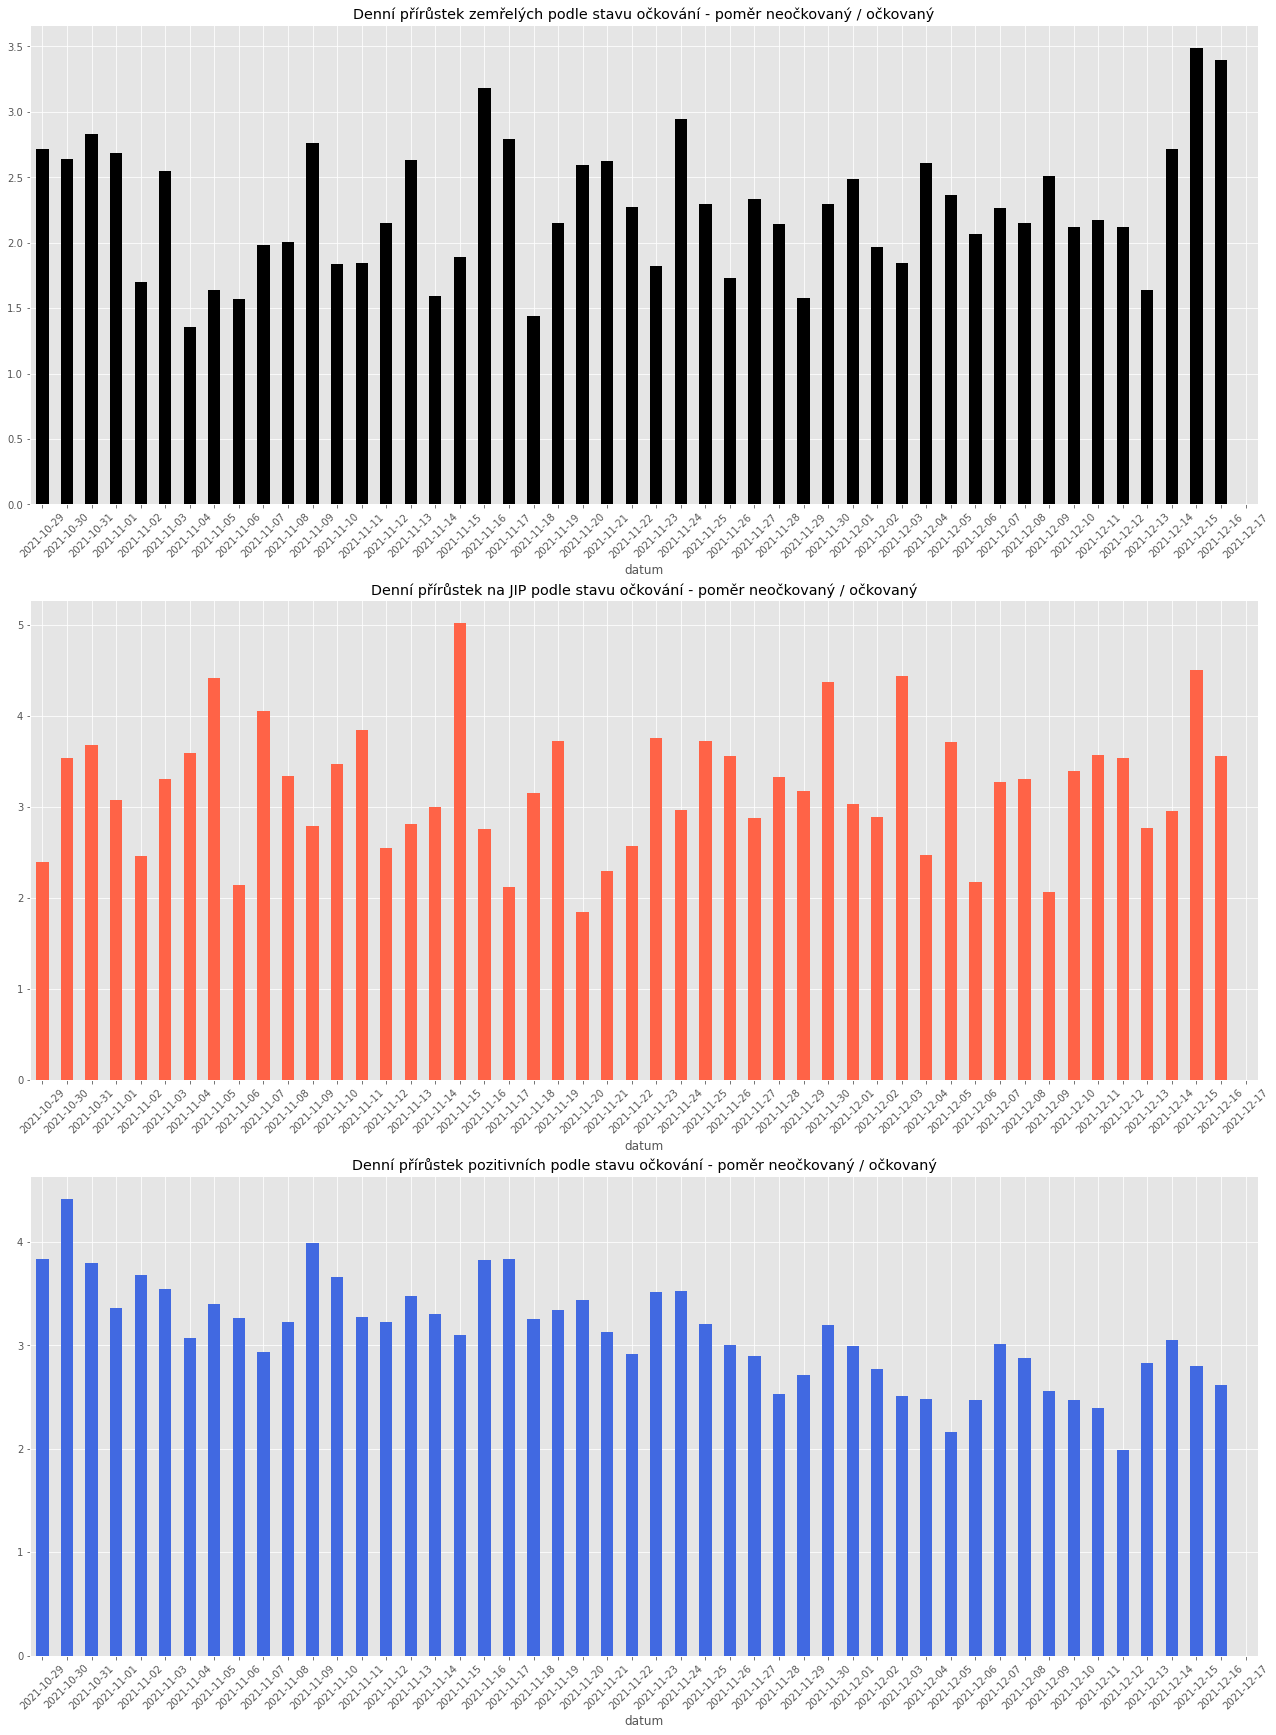

In [10]:
# kolikrát víc neočkovaných než očkovaných 
df_ocko_umrti['neocko_ocko_pomer'] = df_ocko_umrti['zemreli_bez_ockovani_relative'] / df_ocko_umrti['zemreli_ockovani_relative']
df_ocko_jip['neocko_ocko_pomer'] = df_ocko_jip['jip_bez_ockovani_relative'] / df_ocko_jip['jip_ockovani_relative']
df_ocko_positive['neocko_ocko_pomer'] = df_ocko_positive['pozitivni_bez_ockovani_relative'] / df_ocko_positive['pozitivni_ockovani_relative']


fig = plt.figure(figsize=(22,30))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

df_ocko_umrti.plot(x='datum', 
        y=['neocko_ocko_pomer'], 
        kind='bar',
        color=['black'],
        linewidth=3,
        stacked=True,
        grid=True, 
        legend=False,
        ax=ax1,
        title='Denní přírůstek zemřelých podle stavu očkování - poměr neočkovaný / očkovaný')
ax1.tick_params(axis="x", rotation=45)

df_ocko_jip.plot(x='datum', 
        y=['neocko_ocko_pomer'], 
        kind='bar',
        color=['tomato'],
        linewidth=3,
        stacked=True,
        grid=True, 
        legend=False,
        ax=ax2,
        title='Denní přírůstek na JIP podle stavu očkování - poměr neočkovaný / očkovaný')
ax2.tick_params(axis="x", rotation=45)

df_ocko_positive.plot(x='datum', 
        y=['neocko_ocko_pomer'], 
        kind='bar',
        color=['royalblue'],
        linewidth=3,
        stacked=True,
        grid=True, 
        legend=False,
        ax=ax3,
        title='Denní přírůstek pozitivních podle stavu očkování - poměr neočkovaný / očkovaný')
ax3.tick_params(axis="x", rotation=45)

To samé pro věkovou skupinu 40-49
- počet obyvatel ve věku 40-49: 1 775 907
- počet očkovaných 40-44 k 19.11.2021: 529 496
- počet očkovaných 45-49 k 19.11.2021: 583 226


https://onemocneni-aktualne.mzcr.cz/api/v3/umrti?page=1&datum%5Bafter%5D=2021-11-01&vek%5Bgt%5D=40&vek%5Blt%5D=50&apiToken=



In [11]:
residents_40 = 1775907
vax_40 = 529496+583226
novax_40 = residents_40 - vax_40
